## This notebook does three things:
## I. Merges Quast report files for multiple assemblies, subsets metrics of choice, and compares them using Seaborn violin plots.
## II. Takes a spreadsheet of Illumina reads mapped to all assemblies and makes a violin plot comparing read mapping percentages among assembly programs.
## III. Takes a spreadsheet of # contigs, # ORFs, and # annotated KOFams for each assembly and plots the number of annotations/ORF by assembly type

#### Import all required modules

In [4]:
import pandas as pd
import os as os
import glob as glob
import numpy as np
import re as re

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

#### Navigate to your working directory, which should contain both spreadsheets you want to merge

In [13]:
os.chdir("/Users/nastassia.patin/Desktop/Projects/Lasker 2019/PacBio/metaFlye/quast/reports")

## I. Use data from Quast assembly reports to plot various assembly metrics

### Loop through Quast report tsv files, convert to long form, and merge

In [14]:
df = []
for report in glob.glob("*.tsv"):
    a, b = report.split('_q') # For metaflye and Illumina quast reports only
    tsv = pd.read_csv(report, sep='\t')
    #tsv = tsv[['Assembly','contigs']] # for Illumina reports
    tsv = tsv.rename(columns={'assembly': a}) # metaflye and Illumina
    tsv_long = pd.melt(tsv, id_vars='Assembly', value_vars=tsv.columns[1])
    df.append(tsv_long)
    
df_all = pd.concat(df)
df_all = df_all.rename(columns={'Assembly': "Metric", "variable": "Assembly"})

In [25]:
df_all.size

882

In [26]:
df_all.head()

,Metric,Assembly,value
0,# contigs (>= 0 bp),Las19c135_5m-3,27878.0
1,# contigs (>= 1000 bp),Las19c135_5m-3,27788.0
2,# contigs (>= 5000 bp),Las19c135_5m-3,27698.0
3,# contigs (>= 10000 bp),Las19c135_5m-3,9869.0
4,# contigs (>= 25000 bp),Las19c135_5m-3,542.0


#### Save the merged table as a csv

In [27]:
df_all.to_csv("PacBio_metaFlye_assemblies_quast.csv", index=None)

### Upload all quast summaries of interest

In [17]:
os.chdir("/Users/nastassia.patin/Desktop/Projects/Lasker 2019/PacBio/assembly-comparisons")

In [18]:
df_metaflye = pd.read_csv("PacBio_metaFlye_assemblies_quast.csv")
df_hifiasm = pd.read_csv("PacBio_hifiasm-meta_p-ctg_assemblies_quast.csv")
df_illumina = pd.read_csv("Illumina_PacBio_matches_assemblies_quast.csv")
df_hybrid = pd.read_csv("PacBio_hybridSPAdes_assemblies_quast.csv")

In [19]:
df_illumina['Assembly'].unique()

array(['1903c117_50m-2', '1903c122_28m-1', '1903c127_7m-1',
       '1903c123_10m-2', '1903c129_26m-1', '1903c111_10m-2',
       '1903c124_15m-2', 'Las19c135_5m-2', 'Las19c107_10m-1',
       '1903c119_11m-2', '1903c126_45m-2', 'Las19c135_5m-1',
       'Las19c107_10m-2', '1903c126_45m-1', 'Las19c138_27m-1',
       '1903c129_26m-2', '1903c117_50m-1', '1903c122_28m-2',
       '1903c123_10m-1', '1903c127_7m-2', '1903c111_10m-1',
       '1903c144_13m-2', '1903c124_15m-1'], dtype=object)

#### Need to rename hifiasm-meta Assembly names to match others

In [20]:
df_hifiasm[['Assembly', 'suffix']] = df_hifiasm['Assembly'].str.split("_p", n=2, expand=True)
df_hifiasm.head()

,Metric,Assembly,value,suffix
0,# contigs (>= 0 bp),1903c144_13m_3,162.0,_ctg
1,# contigs (>= 1000 bp),1903c144_13m_3,162.0,_ctg
2,# contigs (>= 5000 bp),1903c144_13m_3,162.0,_ctg
3,# contigs (>= 10000 bp),1903c144_13m_3,153.0,_ctg
4,# contigs (>= 25000 bp),1903c144_13m_3,25.0,_ctg


In [21]:
df_hifiasm.loc[:, 'Assembly'] = df_hifiasm.loc[:, 'Assembly'].replace({'_3': '-3'}, regex=True)
df_hifiasm = df_hifiasm.drop(columns=['suffix'])
df_hifiasm.head()

,Metric,Assembly,value
0,# contigs (>= 0 bp),1903c144_13m-3,162.0
1,# contigs (>= 1000 bp),1903c144_13m-3,162.0
2,# contigs (>= 5000 bp),1903c144_13m-3,162.0
3,# contigs (>= 10000 bp),1903c144_13m-3,153.0
4,# contigs (>= 25000 bp),1903c144_13m-3,25.0


### Subset specific metrics

In [22]:
df_ill_sub = df_illumina[(df_illumina['Metric'] == "# contigs (>= 1000 bp)") | 
                (df_illumina['Metric'] == 'N50') |
                   (df_illumina['Metric'] == "# contigs (>= 5000 bp)") |
                    (df_illumina['Metric'] == "# contigs (>= 25000 bp)") |
                   (df_illumina['Metric'] == "# contigs (>= 50000 bp)")]
df_ill_largestcontig = df_illumina[df_illumina['Metric'] == 'Largest contig'] 

In [23]:
df_mfl_sub = df_metaflye[(df_metaflye['Metric'] == "# contigs (>= 1000 bp)") | 
                (df_metaflye['Metric'] == 'N50') |
                   (df_metaflye['Metric'] == "# contigs (>= 5000 bp)") |
                    (df_metaflye['Metric'] == "# contigs (>= 25000 bp)") |
                     (df_metaflye['Metric'] == "# contigs (>= 50000 bp)")]
df_mfl_largestcontig = df_metaflye[df_metaflye['Metric'] == 'Largest contig'] 

In [24]:
df_hifi_sub = df_hifiasm[(df_hifiasm['Metric'] == "# contigs (>= 1000 bp)") | 
                    (df_hifiasm['Metric'] == 'N50') |
                     (df_hifiasm['Metric'] == "# contigs (>= 5000 bp)") |
                     (df_hifiasm['Metric'] == "# contigs (>= 25000 bp)") |
                     (df_hifiasm['Metric'] == "# contigs (>= 50000 bp)")]
df_hifi_largestcontig = df_hifiasm[df_hifiasm['Metric'] == 'Largest contig'] 

In [25]:
df_hyb_sub = df_hybrid[(df_hybrid['Metric'] == "# contigs (>= 1000 bp)") | 
                    (df_hybrid['Metric'] == 'N50') |
                     (df_hybrid['Metric'] == "# contigs (>= 5000 bp)") |
                     (df_hybrid['Metric'] == "# contigs (>= 25000 bp)") |
                     (df_hybrid['Metric'] == "# contigs (>= 50000 bp)")]
df_hyb_largestcontig = df_hybrid[df_hybrid['Metric'] == 'Largest contig'] 

In [26]:
df_ill_sub = df_ill_sub.assign(Assembler = 'Illumina-SPAdes')
df_hifi_sub = df_hifi_sub.assign(Assembler = 'hifiasm-meta')
df_mfl_sub = df_mfl_sub.assign(Assembler = 'metaFlye')
df_hyb_sub = df_hyb_sub.assign(Assembler = 'hybridSPAdes')

In [27]:
df_ill_largestcontig = df_ill_largestcontig.assign(Assembler = 'Illumina-SPAdes')
df_hifi_largestcontig = df_hifi_largestcontig.assign(Assembler = 'Hifiasm-meta')
df_mfl_largestcontig = df_mfl_largestcontig.assign(Assembler = 'metaFlye')
df_hyb_largestcontig = df_hyb_largestcontig.assign(Assembler = 'hybridSPAdes')

In [34]:
df_four = df_ill_largestcontig.append(df_hifi_largestcontig)
df_four = df_four.append(df_mfl_largestcontig)
df_four = df_four.append(df_hyb_largestcontig)

<ipython-input-34-8ebff8713a3c>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_four = df_ill_largestcontig.append(df_hifi_largestcontig)
<ipython-input-34-8ebff8713a3c>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_four = df_four.append(df_mfl_largestcontig)
<ipython-input-34-8ebff8713a3c>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_four = df_four.append(df_hyb_largestcontig)


In [35]:
df_four.head()

,Metric,Assembly,value,Assembler
13,Largest contig,1903c117_50m-2,6150.0,Illumina-SPAdes
34,Largest contig,1903c122_28m-1,101689.0,Illumina-SPAdes
55,Largest contig,1903c127_7m-1,54920.0,Illumina-SPAdes
76,Largest contig,1903c123_10m-2,11370.0,Illumina-SPAdes
97,Largest contig,1903c129_26m-1,54139.0,Illumina-SPAdes


#### Need to do this next line for the Illumina assemblies since there are duplicates

In [36]:
df_four[['Assembly', 'Replicate']] = df_four['Assembly'].str.split("-", n=1, expand=True)

In [37]:
df_four.head()

,Metric,Assembly,value,Assembler,Replicate
13,Largest contig,1903c117_50m,6150.0,Illumina-SPAdes,2
34,Largest contig,1903c122_28m,101689.0,Illumina-SPAdes,1
55,Largest contig,1903c127_7m,54920.0,Illumina-SPAdes,1
76,Largest contig,1903c123_10m,11370.0,Illumina-SPAdes,2
97,Largest contig,1903c129_26m,54139.0,Illumina-SPAdes,1


### Violin plots by metric with average values of each assembler plotted

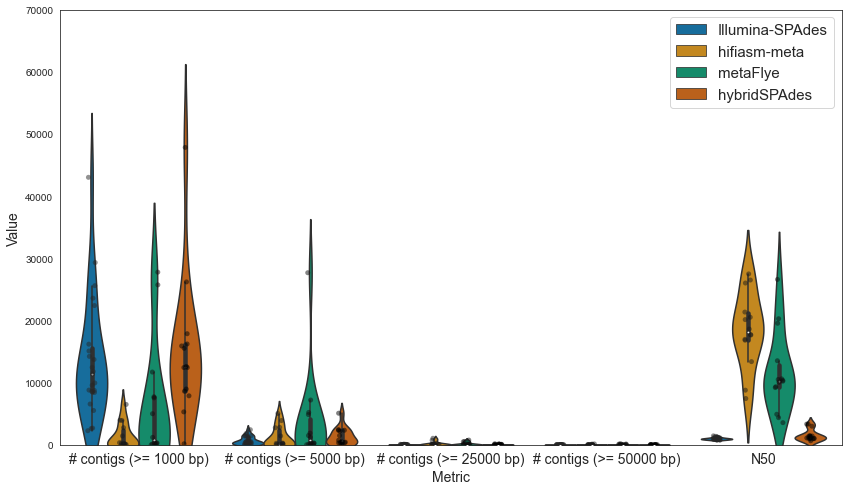

In [146]:
plt.figure(figsize=(14,8))
sns.set_style("white")
grped_vplot = sns.violinplot(data=df_four, x="Metric", y="value", hue="Assembler", 
              palette="colorblind", scale='width') # split=True, inner="quart", linewidth=1, 
grped_vplot = sns.stripplot(data=df_four, x="Metric", y="value", color="k", alpha=0.5, dodge=True, hue="Assembler")
#plt.title("Assembly metrics by program")
plt.ylabel("Value", size=14)
plt.xlabel("Metric", size=14)
plt.xticks(size=14)
plt.ylim(0, 70000)ax.set_xticks([0,1,3,5])

# Let us first get legend information from the plot object
handles, labels = grped_vplot.get_legend_handles_labels()
# specify just one legend
l = plt.legend(handles[0:4], labels[0:4], prop={'size': 15})

plt.savefig("assemblers_four_metrics_violin.svg", format='svg', dpi=1200, bbox_inches='tight')
plt.show()

### Scatter plot of a metric by sample sets

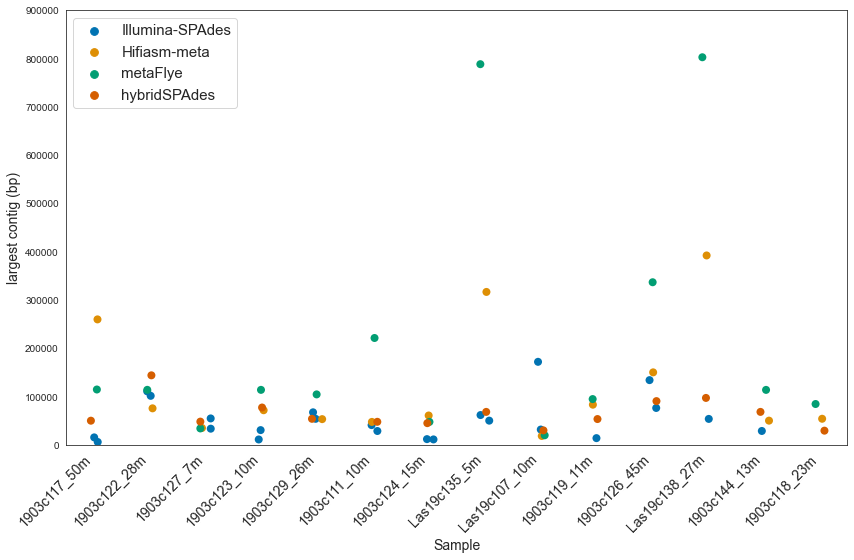

In [42]:
plt.figure(figsize=(14,8))
sns.set_style("white")
grped_vplot = sns.stripplot(data=df_four, x="Assembly", y="value",
                             hue="Assembler", color="k", dodge=False, palette="colorblind", size=8) # [df_four["Metric"] == "# contigs (>= 1000 bp)"]
#plt.title("Assembly metrics by program")
plt.ylabel("largest contig (bp)", size=14)
plt.xlabel("Sample", size=14)
plt.xticks(rotation=45, ha='right', size=14)
plt.ylim(0, 900000)

# Let us first get legend information from the plot object
handles, labels = grped_vplot.get_legend_handles_labels()
# specify just one legend
l = plt.legend(handles[0:4], labels[0:4], prop={'size': 15})

plt.savefig("assemblers_four_largetscontigs_scatter.svg", format='svg', dpi=1200, bbox_inches='tight')
plt.show()

## II. Plot mapped Illumina reads for each set of assemblies

In [3]:
os.chdir("/Users/nastassia.patin/Desktop/Projects/Lasker2019/Long read paper/mSystems/Revisions")
mapping = pd.read_csv("mapped_reads_comparison_v2.csv")
mapping.head()

,Sample,Assembler,Illumin rep,Total reads,# number reads mapped,% reads mapped
0,1903c111_10m-3,Hifiasm-meta,2,26819212,1948.0,0.0
1,1903c111_10m-3,Hifiasm-meta,1,22944790,4013.0,0.0
2,1903c117_50m-3,Hifiasm-meta,1,15783468,1198422.0,7.6
3,1903c117_50m-3,Hifiasm-meta,2,39962582,2604519.0,6.5
4,1903c118_23m-3,Hifiasm-meta,2,18211920,4966.0,0.0


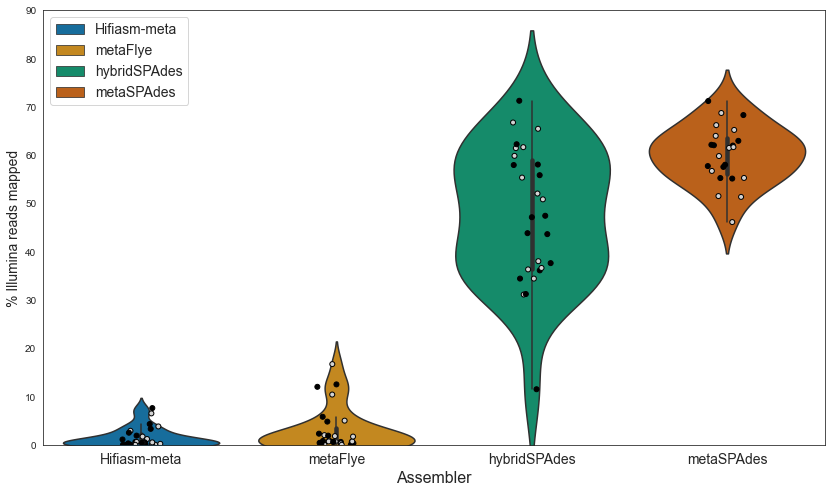

In [14]:
plt.figure(figsize=(14,8))
sns.set_style("white")
points_pal = ["black", "lightgrey"]
customPalette = sns.set_palette(sns.color_palette(points_pal))

vplot = sns.violinplot(data=mapping, x="Assembler", y="% reads mapped", hue="Assembler",
                             palette="colorblind", dodge=False)  
vplot = sns.stripplot(data=mapping, x="Assembler", y="% reads mapped", color="k", hue="Illumin rep", 
                            palette=points_pal, dodge=False, linewidth=1)
#plt.title("Assembly metrics by program")
plt.ylabel("% Illumina reads mapped", size=14)
plt.xlabel("Assembler", size=16)
plt.xticks(size=14)
plt.ylim(0, 90)

# Let us first get legend information from the plot object
handles, labels = vplot.get_legend_handles_labels()
# specify just one legend
l = plt.legend(handles[0:4], labels[0:4], prop={'size': 14}, loc="upper left")

plt.savefig("FigS3_v2.svg", format='svg', dpi=1200, bbox_inches='tight')
plt.show()

## III. Plot the number of ORFs with KEGG annotations for each assembly type

In [7]:
os.chdir("/Users/nastassia.patin/Desktop/Projects/Lasker2019/Long read paper/mSystems/Revisions")
kofams = pd.read_csv("assembly_comparisons_kofams.csv")
kofams.head()

,Sample,Assembler,Contigs,ORFs,KOfam hits,Annotated ORFs (%)
0,1903c111_10m-3,Hifiasm-meta,103,1742,120,0.07
1,1903c117_50m-3,Hifiasm-meta,6497,65310,19760,0.30
2,1903c118_23m-3,Hifiasm-meta,14,545,20,0.04
3,1903c119_11m-3,Hifiasm-meta,3958,33139,12288,0.37
4,1903c122_28m-3,Hifiasm-meta,114,2223,125,0.06


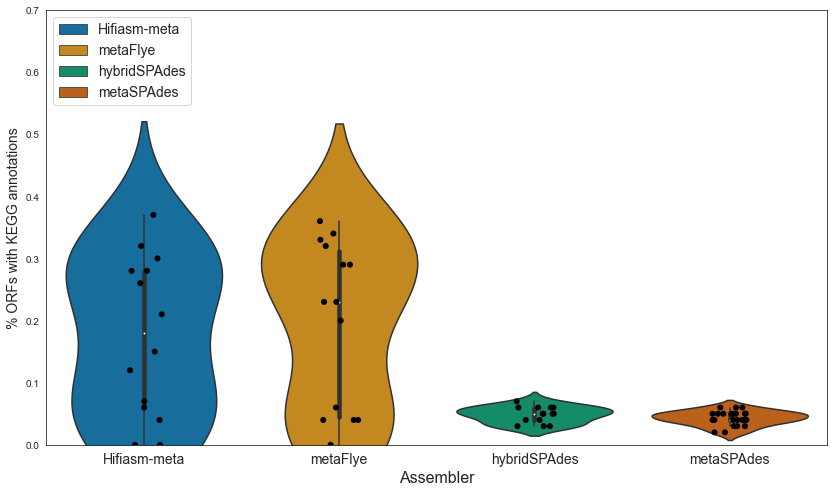

In [12]:
plt.figure(figsize=(14,8))
sns.set_style("white")

vplot = sns.violinplot(data=kofams, x="Assembler", y="Annotated ORFs (%)", hue="Assembler",
                             palette="colorblind", dodge=False)  
vplot = sns.stripplot(data=kofams, x="Assembler", y="Annotated ORFs (%)", color="k",  
                            dodge=False, linewidth=1) # hue="Illumin rep",

#plt.title("Assembly metrics by program")
plt.ylabel("% ORFs with KEGG annotations", size=14)
plt.xlabel("Assembler", size=16)
plt.xticks(size=14)
plt.ylim(0, 0.7)

# Let us first get legend information from the plot object
handles, labels = vplot.get_legend_handles_labels()
# specify just one legend
l = plt.legend(handles[0:4], labels[0:4], prop={'size': 14}, loc="upper left")

plt.savefig("ORFs_annotated_violins.svg", format='svg', dpi=1200, bbox_inches='tight')
plt.show()